# Tasa de Suicidios
#### Jose Carlos Pimienta Ibarra

En este proyecto se evaluara informacion sobre informacion de suicidios por pais desde 1985 a 2016. Esta informacion el cual fue encontrado en kaggle fue recopilado desde distintos sitios, los cuales incluyen el banco mundial, la organizacion mundial de la salud entre otros.

El dataset incluye las sigueinte columnas:
- País
- Año
- Sexo
- Edad
- Número de suicidios
- Población
- Suicidos por cada 100,000 habitantes
- Pais-Año
- Índice de desarrollo humano por año
- Producto Interno Bruto por año (PIB)
- PIB per capita
- Generación
    

Importamos las librerias de pyspark y lo inicializamos el contexto para poder usarlo

In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark import sql
sc = SparkContext.getOrCreate()
sqlContext = sql.SQLContext(sc)

In [11]:
data = (sqlContext.read.format("com.databricks.spark.csv")
        .option("header", "true")
        .load("master.csv"))
print(data)

DataFrame[country: string, year: string, sex: string, age: string, suicides_no: string, population: string, suicides/100k pop: string, country-year: string, HDI for year: string,  gdp_for_year ($) : string, gdp_per_capita ($): string, generation: string]


En la impresion anterior podemos ver el tipo de valor que tiene cada columna el dataframe.

A continuación se mostraran los primeros 20 renglones de dataframe generado

In [12]:
data.show()

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year| gdp_for_year ($) |gdp_per_capita ($)|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|Albania|1987|  male|15-24 years|         21|    312900|             6.71| Albania1987|        null|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|35-54 years|         16|    308000|             5.19| Albania1987|        null|     2,156,624,900|               796|         Silent|
|Albania|1987|female|15-24 years|         14|    289700|             4.83| Albania1987|        null|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|  75+ years|          1|     21800|             4

 Podemos ver que en los primeros 20 renglones el valor de la columna **HDI for year** es **null**.
 Usando la herramiente _openRefine_ podemos ver que en esa columna de los __27,820__ registros **19456** son nulos, esto significa que en la columna **HDI for year** el ** _69.9%_ ** de los datos  es nulo por lo que podemos decir que esa columnna no nos servira para analisis por lo que podemos eliminar esa colummna.

In [16]:
print(data.columns)

['country', 'year', 'sex', 'age', 'suicides_no', 'population', 'suicides/100k pop', 'country-year', 'HDI for year', ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation']


# Total de suicidios por pais

In [6]:
data2 = (sqlContext.read.format("com.databricks.spark.csv")
        .option("header", "true")
        .load("TotalSuicides.csv"))
print(data2)

DataFrame[Ã¯Â»Â¿country: string, Total_suicides: string]


cambiamos el tipo de dato de la columna Total_suicides a int y manejamos nombres de columnas

In [13]:
from pyspark.sql.types import IntegerType

data2 = data2.withColumn("total_suicides", data2["total_suicides"].cast(IntegerType()))

data2.show()

+--------------------+--------------+
|       Ã¯Â»Â¿country|Total_suicides|
+--------------------+--------------+
|             Albania|          1970|
| Antigua and Barbuda|            11|
|           Argentina|         82219|
|             Armenia|          1905|
|               Aruba|           101|
|           Australia|         70111|
|             Austria|         50073|
|          Azerbaijan|          1656|
|             Bahamas|            93|
|             Bahrain|           463|
|            Barbados|           177|
|             Belarus|         59892|
|             Belgium|         62761|
|              Belize|           348|
|Bosnia and Herzeg...|           318|
|              Brazil|        226613|
|            Bulgaria|         36388|
|          Cabo Verde|            42|
|              Canada|        107561|
|               Chile|         40895|
+--------------------+--------------+
only showing top 20 rows



Transformamos el dataframe de pyspark por uno de Pandas.

In [17]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

pdf = data2.toPandas()

pdf

,Ã¯Â»Â¿country,Total_suicides
0,Albania,1970
1,Antigua and Barbuda,11
2,Argentina,82219
3,Armenia,1905
4,Aruba,101
5,Australia,70111
6,Austria,50073
7,Azerbaijan,1656
8,Bahamas,93
9,Bahrain,463


Ya que el dataframe es de pandas hacemos un diccionario con el nombre del país y con el numero de suicidios de ese pais. Con el diccionario anterior haremos un wordcloud de los suicidios en paises.

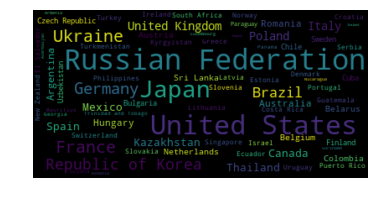

In [27]:
d = {}

for a, x  in pdf.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
#plt.figure(figsize=(25,25))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [42]:
print(d)

{'Generation X': 1532804, 'Silent': 1781744, 'G.I. Generation': 510009, 'Boomers': 2284498, 'Millenials': 623459, 'Generation Z': 15906}


En el grafico anterior podemos ver que los paises con mas suicidios registrados se encuentra Rusia, USA y Japon. Pero este resultado es tomando en cuenta el total de suicidios sin tomar en cuenta la diferencia entre la cantidad de habitantes entre cada pais

In [34]:
dataC = (sqlContext.read.format("com.databricks.spark.csv")
        .option("header", "true")
        .load("master.csv"))

dataC = dataC.withColumn("suicides_no", dataC["suicides_no"].cast(IntegerType()))

dataC.show()
pDataC = dataC.toPandas()
pDataC

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year| gdp_for_year ($) |gdp_per_capita ($)|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|Albania|1987|  male|15-24 years|         21|    312900|             6.71| Albania1987|        null|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|35-54 years|         16|    308000|             5.19| Albania1987|        null|     2,156,624,900|               796|         Silent|
|Albania|1987|female|15-24 years|         14|    289700|             4.83| Albania1987|        null|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|  75+ years|          1|     21800|             4

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,None,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,None,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,None,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,None,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,None,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,None,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,None,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,None,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,None,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0,Albania1987,None,"2,156,624,900",796,Generation X


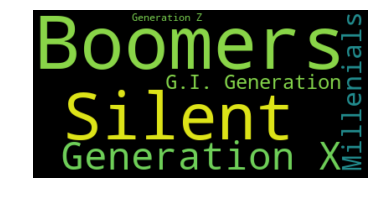

In [41]:
d = {'Generation X': 0, 
     'Silent': 0, 
     'G.I. Generation': 0, 
     'Boomers': 0, 
     'Millenials': 0, 
     'Generation Z': 0}

for a0, a1, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12  in pDataC.values:
    d[a12] += a5

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
#plt.figure(figsize=(25,25))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()